<a href="https://colab.research.google.com/github/KU-BIG/KUBIG_2025_SPRING/blob/main/KUBIG_2025_SPRING/KUBIG%20CONFERENCE/DA(NLP)%20/Domain_adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [ ]:
!pip install Korpora

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset
from Korpora import Korpora
import tensorflow_datasets as tfds
import random
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 시각화 코드

In [ ]:
def visualize_domain_label_features(feature_extractor, dataset, device, tokenizer, sample_size=800):
    feature_extractor.eval()

    if len(dataset) > sample_size:
        indices = np.random.choice(len(dataset), sample_size, replace=False)
    else:
        indices = range(len(dataset))

    features = []
    domain_labels = []
    sentiment_labels = []

    with torch.no_grad():
        for idx in indices:
            encodings, sentiment_label, domain_label = dataset[idx]
            for k in encodings:
                encodings[k] = encodings[k].unsqueeze(0).to(device)
            feature = feature_extractor(**encodings).last_hidden_state[:, 0]
            features.append(feature.cpu().numpy())
            domain_labels.append(domain_label.item())
            sentiment_labels.append(sentiment_label.item())

    features = np.concatenate(features, axis=0)
    domain_labels = np.array(domain_labels)
    sentiment_labels = np.array(sentiment_labels)

    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(8,6))

    markers = ['o', 's']  # 긍정: o, 부정: s
    colors = ['blue', 'red']  # 영어: 파랑, 한국어: 빨강

    for domain in [0,1]:
        for sentiment in [0,1]:
            idxs = (domain_labels == domain) & (sentiment_labels == sentiment)
            plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1],
                        c=colors[domain], marker=markers[sentiment],
                        alpha=0.6, label=f"{'English' if domain==0 else 'Korean'} - {'Positive' if sentiment==1 else 'Negative'}",
                        s=30)

    plt.legend()
    plt.title("t-SNE Visualization by Domain and Sentiment Label")
    plt.show()

# DANN

In [ ]:
# Gradient Reversal Layer 구현
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

def grad_reverse(x, alpha=1.0):
    return GradReverse.apply(x, alpha)

# 1. 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 데이터 준비
# 영어 IMDB
import tensorflow_datasets as tfds
train_ds_en, test_ds_en = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True)

def tfds_to_list(dataset):
    texts = []
    labels = []
    for text, label in tfds.as_numpy(dataset):
        texts.append(text.decode('utf-8'))
        labels.append(int(label))
    return texts, labels

X_train_en, y_train_en = tfds_to_list(train_ds_en)
X_val_en, y_val_en = tfds_to_list(test_ds_en)

# 한국어 NSMC 10% 샘플
corpus = Korpora.load("nsmc")
X_nsmc = corpus.get_all_texts()
y_nsmc = list(map(int, corpus.get_all_labels()))

random.seed(42)
sample_size = int(len(X_nsmc) * 0.1)
sample_indices = random.sample(range(len(X_nsmc)), sample_size)
X_nsmc_sampled = [X_nsmc[i] for i in sample_indices]
y_nsmc_sampled = [y_nsmc[i] for i in sample_indices]

# 3. 토크나이저, 모델 초기화
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
feature_extractor = AutoModel.from_pretrained("xlm-roberta-base").to(device)
feature_extractor.eval()  # 평가모드 (freeze feature extractor도 가능하지만, fine-tuning 원하면 train모드로 바꿈)

# 4. CLS 임베딩 추출 함수 (배치 단위)
def extract_cls_embeddings(texts, batch_size=64):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            output = feature_extractor(**enc).last_hidden_state[:, 0]
        embeddings.append(output.cpu())
    return torch.cat(embeddings)

# 5. Dataset 생성 (도메인 레이블 추가)
# domain label: 0 = 영어, 1 = 한국어
def make_dataset(texts, labels, domain_label):
    return [(t, l, domain_label) for t, l in zip(texts, labels)]

train_data_en = make_dataset(X_train_en, y_train_en, 0)
train_data_ko = make_dataset(X_nsmc_sampled, y_nsmc_sampled, 1)

# 합쳐서 학습 데이터셋
train_data = train_data_en + train_data_ko

# 6. Dataloader 준비 (토크나이저 + feature extractor 내에서 처리)
class TextDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        text, label, domain = self.data[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors='pt')
        # squeeze to remove batch dim
        for k in encoding:
            encoding[k] = encoding[k].squeeze(0)
        return encoding, torch.tensor(label, dtype=torch.float32), torch.tensor(domain, dtype=torch.float32)

train_dataset = TextDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.UDTP0O_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.UDTP0O_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.UDTP0O_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.

    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



[nsmc] download ratings_train.txt: 14.6MB [00:01, 11.0MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 7.95MB/s]                            
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

💡 학습 전 도메인/감정 분포 시각화


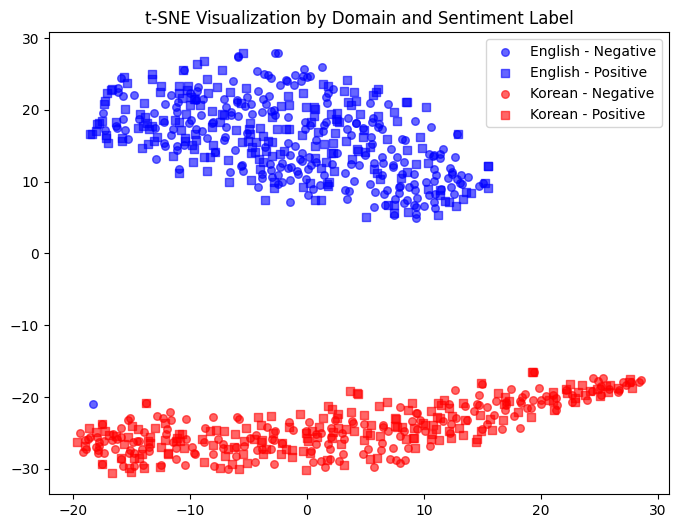

In [ ]:
print("💡 학습 전 도메인/감정 분포 시각화")
visualize_domain_label_features(feature_extractor, train_dataset, device, tokenizer)

In [ ]:
# 7. 모델 정의
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim=768):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.classifier(x)

class DomainClassifier(nn.Module):
    def __init__(self, input_dim=768):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.classifier(x)

# 8. 모델 인스턴스 및 옵티마이저
sentiment_clf = SentimentClassifier().to(device)
domain_clf = DomainClassifier().to(device)

# 옵티마이저 통합 (feature extractor 포함)
optimizer = optim.Adam(list(feature_extractor.parameters()) +
                       list(sentiment_clf.parameters()) +
                       list(domain_clf.parameters()), lr=1e-4)

# 9. 손실 함수
criterion_sentiment = nn.BCEWithLogitsLoss()
criterion_domain = nn.BCEWithLogitsLoss()

# 10. 학습 루프 (DANN)
epochs = 5
alpha = 1.0  # GRL 세기 조절 파라미터

for epoch in range(epochs):
    feature_extractor.train()
    sentiment_clf.train()
    domain_clf.train()

    total_sent_loss = 0
    total_domain_loss = 0

    all_sent_preds, all_sent_labels = [], []
    all_domain_preds, all_domain_labels = [], []

    for batch in train_loader:
        encodings, sentiment_labels, domain_labels = batch
        for k in encodings:
            encodings[k] = encodings[k].to(device)
        sentiment_labels = sentiment_labels.to(device).unsqueeze(1)
        domain_labels = domain_labels.to(device).unsqueeze(1)

        optimizer.zero_grad()

        features = feature_extractor(**encodings).last_hidden_state[:, 0]  # CLS 임베딩

        # 감정 분류기 순전파
        sent_logits = sentiment_clf(features)
        sent_loss = criterion_sentiment(sent_logits, sentiment_labels)

        # 도메인 분류기 순전파 (GRL 적용)
        reversed_features = grad_reverse(features, alpha)
        domain_logits = domain_clf(reversed_features)
        domain_loss = criterion_domain(domain_logits, domain_labels)

        loss = sent_loss + domain_loss
        loss.backward()
        optimizer.step()

        total_sent_loss += sent_loss.item()
        total_domain_loss += domain_loss.item()

        sent_probs = torch.sigmoid(sent_logits)
        sent_preds = (sent_probs >= 0.5).float()

        domain_probs = torch.sigmoid(domain_logits)
        domain_preds = (domain_probs >= 0.5).float()

        all_sent_preds.extend(sent_preds.cpu().numpy().astype(int))
        all_sent_labels.extend(sentiment_labels.cpu().numpy().astype(int))
        all_domain_preds.extend(domain_preds.cpu().numpy().astype(int))
        all_domain_labels.extend(domain_labels.cpu().numpy().astype(int))

    sent_acc = accuracy_score(all_sent_labels, all_sent_preds)
    sent_f1 = f1_score(all_sent_labels, all_sent_preds)
    domain_acc = accuracy_score(all_domain_labels, all_domain_preds)

    print(f"[Epoch {epoch+1}] Sent Loss: {total_sent_loss/len(train_loader):.4f}, Domain Loss: {total_domain_loss/len(train_loader):.4f}")
    print(f" Sentiment Acc: {sent_acc:.4f}, Sentiment F1: {sent_f1:.4f}, Domain Acc: {domain_acc:.4f}")

# 11. 한국어 NSMC 평가 (도메인 적응 효과 확인)
# 한국어 데이터셋 임베딩 + 평가
# NSMC 평가용 DataLoader
eval_dataset = TextDataset(list(zip(X_nsmc_sampled, y_nsmc_sampled, [1]*len(y_nsmc_sampled))), tokenizer)
eval_loader = DataLoader(eval_dataset, batch_size=64)

sentiment_clf.eval()
feature_extractor.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in eval_loader:
        encodings, labels, _ = batch
        for k in encodings:
            encodings[k] = encodings[k].to(device)
        labels = labels.to(device).unsqueeze(1)

        features = feature_extractor(**encodings).last_hidden_state[:, 0]
        logits = sentiment_clf(features)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy().astype(int))
        all_labels.extend(labels.cpu().numpy().astype(int))

acc_ko = accuracy_score(all_labels, all_preds)
f1_ko = f1_score(all_labels, all_preds)
print(f"NSMC Accuracy (한국어 평가): {acc_ko:.4f} | F1: {f1_ko:.4f}")

[Epoch 1] Sent Loss: 0.6971, Domain Loss: 1.4149
 Sentiment Acc: 0.4983, Sentiment F1: 0.4995, Domain Acc: 0.0022
[Epoch 2] Sent Loss: 0.6960, Domain Loss: 0.8518
 Sentiment Acc: 0.5027, Sentiment F1: 0.5024, Domain Acc: 0.0374


KeyboardInterrupt: 

In [ ]:
# 7. 모델 정의
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim=768):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.classifier(x)

class DomainClassifier(nn.Module):
    def __init__(self, input_dim=768):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.classifier(x)

# 8. 모델 인스턴스 및 옵티마이저
sentiment_clf = SentimentClassifier().to(device)
domain_clf = DomainClassifier().to(device)

# 옵티마이저 통합 (feature extractor 포함)
optimizer = optim.Adam(list(feature_extractor.parameters()) +
                       list(sentiment_clf.parameters()) +
                       list(domain_clf.parameters()), lr=2e-4)

# 9. 손실 함수
criterion_sentiment = nn.BCEWithLogitsLoss()
criterion_domain = nn.BCEWithLogitsLoss()

# 10. 학습 루프 (DANN)
epochs = 5
alpha = 0.5  # GRL 세기 조절 파라미터

for epoch in range(epochs):
    feature_extractor.train()
    sentiment_clf.train()
    domain_clf.train()

    total_sent_loss = 0
    total_domain_loss = 0

    all_sent_preds, all_sent_labels = [], []
    all_domain_preds, all_domain_labels = [], []

    for batch in train_loader:
        encodings, sentiment_labels, domain_labels = batch
        for k in encodings:
            encodings[k] = encodings[k].to(device)
        sentiment_labels = sentiment_labels.to(device).unsqueeze(1)
        domain_labels = domain_labels.to(device).unsqueeze(1)

        optimizer.zero_grad()

        features = feature_extractor(**encodings).last_hidden_state[:, 0]  # CLS 임베딩

        # 감정 분류기 순전파
        sent_logits = sentiment_clf(features)
        sent_loss = criterion_sentiment(sent_logits, sentiment_labels)

        # 도메인 분류기 순전파 (GRL 적용)
        reversed_features = grad_reverse(features, alpha)
        domain_logits = domain_clf(reversed_features)
        domain_loss = criterion_domain(domain_logits, domain_labels)

        loss = sent_loss + domain_loss
        loss.backward()
        optimizer.step()

        total_sent_loss += sent_loss.item()
        total_domain_loss += domain_loss.item()

        sent_probs = torch.sigmoid(sent_logits)
        sent_preds = (sent_probs >= 0.5).float()

        domain_probs = torch.sigmoid(domain_logits)
        domain_preds = (domain_probs >= 0.5).float()

        all_sent_preds.extend(sent_preds.cpu().numpy().astype(int))
        all_sent_labels.extend(sentiment_labels.cpu().numpy().astype(int))
        all_domain_preds.extend(domain_preds.cpu().numpy().astype(int))
        all_domain_labels.extend(domain_labels.cpu().numpy().astype(int))

    sent_acc = accuracy_score(all_sent_labels, all_sent_preds)
    sent_f1 = f1_score(all_sent_labels, all_sent_preds)
    domain_acc = accuracy_score(all_domain_labels, all_domain_preds)

    print(f"[Epoch {epoch+1}] Sent Loss: {total_sent_loss/len(train_loader):.4f}, Domain Loss: {total_domain_loss/len(train_loader):.4f}")
    print(f" Sentiment Acc: {sent_acc:.4f}, Sentiment F1: {sent_f1:.4f}, Domain Acc: {domain_acc:.4f}")

# 11. 한국어 NSMC 평가 (도메인 적응 효과 확인)
# 한국어 데이터셋 임베딩 + 평가
# NSMC 평가용 DataLoader
eval_dataset = TextDataset(list(zip(X_nsmc_sampled, y_nsmc_sampled, [1]*len(y_nsmc_sampled))), tokenizer)
eval_loader = DataLoader(eval_dataset, batch_size=64)

sentiment_clf.eval()
feature_extractor.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in eval_loader:
        encodings, labels, _ = batch
        for k in encodings:
            encodings[k] = encodings[k].to(device)
        labels = labels.to(device).unsqueeze(1)

        features = feature_extractor(**encodings).last_hidden_state[:, 0]
        logits = sentiment_clf(features)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy().astype(int))
        all_labels.extend(labels.cpu().numpy().astype(int))

acc_ko = accuracy_score(all_labels, all_preds)
f1_ko = f1_score(all_labels, all_preds)
print(f"NSMC Accuracy (한국어 평가): {acc_ko:.4f} | F1: {f1_ko:.4f}")

[Epoch 1] Sent Loss: 0.6964, Domain Loss: 0.8657
 Sentiment Acc: 0.5011, Sentiment F1: 0.4665, Domain Acc: 0.4427
[Epoch 2] Sent Loss: 0.6947, Domain Loss: 0.7792
 Sentiment Acc: 0.5027, Sentiment F1: 0.4540, Domain Acc: 0.3785
[Epoch 3] Sent Loss: 0.6934, Domain Loss: 0.6905
 Sentiment Acc: 0.5045, Sentiment F1: 0.2162, Domain Acc: 0.5555
[Epoch 4] Sent Loss: 0.6935, Domain Loss: 0.6990
 Sentiment Acc: 0.5004, Sentiment F1: 0.2365, Domain Acc: 0.5063


KeyboardInterrupt: 

In [ ]:
save_path = "dann_sentiment_model.pth"

torch.save({
    'feature_extractor': feature_extractor.state_dict(),
    'sentiment_clf': sentiment_clf.state_dict(),
    'domain_clf': domain_clf.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epoch,
}, save_path)

print(f"모델 저장 완료: {save_path}")

In [ ]:
from google.colab import files
files.download("dann_sentiment_model.pth")

In [ ]:
# # 모델 불러오기
# checkpoint = torch.load("dann_sentiment_model.pth", map_location=device)

# feature_extractor.load_state_dict(checkpoint['feature_extractor'])
# sentiment_clf.load_state_dict(checkpoint['sentiment_clf'])
# domain_clf.load_state_dict(checkpoint['domain_clf'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch'] + 1  # 다음 epoch부터 시작

# print(f"모델 로드 완료. {start_epoch} epoch부터 재개 가능.")

## t-SNE 시각화

In [ ]:
visualize_domain_label_features(feature_extractor, train_dataset, device, tokenizer)